# The Golden Age of Rap: An Analysis

In the music and hip-hop scene, deciding which generation was the "Golden Age of Rap" is a [highly](https://en.wikipedia.org/wiki/Golden_age_hip_hop) [debated](https://www.washingtonpost.com/graphics/entertainment/golden-age-of-hip-hop/) [topic](http://www.factmag.com/2016/02/03/hip-hop-golden-age/). The older generation of hip-hop fans tend to make the argument that the 1990s was the true Golden Age of Rap with artist like Biggie Smalls, Tupac Shakur, and Nas shaking up the scene with their unapologetic and candid raps about life in the city. On the other hand, fans of the newer generation of rap argue that lyricism still plays an important role in the hip-hop scene with artists like Kendrick Lamar and J. Cole.

The argument that rap in the 1990s was more lyrical than modern rap is one that is touted often by the so-called "old heads" - fans of '90s rap. As a big fan of the genre myself, I certainly see where they're coming from. 

Here are a few lines from Nas' "The World is Yours" (1994):

> I sip the Dom P, watchin' Gandhi 'til I'm charged, then

> Writin' in my book of rhymes, all the words past the margin

> Behold the mic I'm throbbin', mechanical movement

> Understandable smooth sh\*t that murderers move with

and Lil Pump's "Gucci Gang" (2017):

> Gucci gang, Gucci gang, Gucci gang (Gucci gang)

> Gucci gang, Gucci gang, Gucci gang, Gucci gang (Gucci gang)

> Gucci gang, Gucci gang, Gucci gang (Gucci gang)

> Spend three racks on a new chain (huh?)

Although these examples are certainly not representative of all music from both time periods, comparisons between single verses are used fairly often in debates about the quality of rap across time periods.

Instead of isolated comparisons, let's take a look at some of the most popular rap songs from the 1990s and 2010s and see if the '90s were truly the Golden Age of Rap.

## Data scraping

To determine the Golden Age of Rap, we are first going to take a look at the lyrical content of the most popular songs from the 1990s and 2010s. We are going to scrape our song popularity data from [Billboard's Hot Rap Songs](https://www.billboard.com/charts/rap-song) and lyrics from [genius.com](https://genius.com/). We'll look at the number of weeks songs remained on the Billboard charts across two 7-year periods: 1990-1997 and 2010-2017. 

First, we'll scrape the Billboard chart data:

In [89]:
import re
import time
import json
import requests
import util
import zlib
from bs4 import BeautifulSoup
import pandas as pd
import urllib.parse as urllib
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
import seaborn
matplotlib.style.use('ggplot')

def scrape_billboard(start_url, end_url):
    ''' 
        Scrapes chart data from Billboard. 
        Starts at start_url and continues to the next week
        until end_url is reached
    '''
    result = []
    current_url = start_url
    while current_url != end_url:
        print('checking {}'.format(current_url))
        response = requests.get(current_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        # for each row in the week's chart, extract artist & song information
        chart_items = soup.find_all('article', class_='chart-row')
        for row in chart_items:
            ranking = row.find('span', class_='chart-row__current-week').text.strip()
            title = row.find('h2', class_='chart-row__song').text.strip()
            artist = row.find(class_='chart-row__artist').text.strip()
            result.append({
                'rank': ranking,
                'title': title,
                'artist': artist
            })
        
        # if an empty page is returned, sleep and try to scrape the page again
        nav = soup.find('nav', class_='chart-nav')
        if nav is None:
            time.sleep(10)
        else:
            next_url = nav.find('a', {'data-tracklabel': 'Week-next'})['href']
            next_url = 'http://www.billboard.com' + next_url
            current_url = next_url
    return pd.DataFrame(result)

# specify start and end URLs
start_90s = 'http://www.billboard.com/charts/rap-song/1990-01-06'
end_90s   = 'http://www.billboard.com/charts/rap-song/1998-01-03'

start_10s = 'http://www.billboard.com/charts/rap-song/2010-01-02'
end_10s   = 'http://www.billboard.com/charts/rap-song/2017-12-23'

# commented out scraping to save time
# charts_90s = scrape_billboard(start_90s, end_90s)
# charts_10s = scrape_billboard(start_10s, end_10s)
# charts_90s.to_csv('csv/90s-charts.csv')
# charts_10s.to_csv('csv/10s-charts.csv')

charts_90s = pd.read_csv('csv/90s-charts.csv')
charts_10s = pd.read_csv('csv/10s-charts.csv')

Now that we have our Billboard chart data, we want to find out which songs were the most popular for the time period. Instead of gathering information for every rap song that was ever on the Billboard charts during the time period,  we'll scrape lyric data for the 50 songs in each time period that had the most weeks on the Billboard charts.

In [32]:
def get_top(df, limit=50):
    ''' Get songs from dataframe with most weeks on Billboard charts '''
    weeks = {}
    for (index, row) in df.iterrows():
        artist = row['artist']
        song = row['title']
        if (artist,song) in weeks:
            weeks[(artist,song)] += 1
        else:
            weeks[(artist,song)] = 1
    sorted_keys = sorted(weeks, key=weeks.get, reverse=True)[:limit]
    top_list = [{ 'artist': artist, 'song': song, 'weeks': weeks[artist,song]} for (artist,song) in sorted_keys]
    return pd.DataFrame(top_list)

top_songs_90s = get_top(charts_90s)
top_songs_10s = get_top(charts_10s)

For each song in our top 50, we want to scrape [Genius](https://genius.com) for the lyric data. The tricky part is going to be programmatically getting the URLs to each lyric page. Luckily, Genius offers an API endpoint for searching tracks via keywords. In order to automate our searching, we'll need to standardize punctuation in our song titles / artist names, define a `match_percentage` function to check how well a search result matches, and come up with a threshold to consider a search result a match.

In addition, we'll take into account a search result's position in the results list to take Genius' search algorithm into account as well.

In [37]:
# loading our credentials for the Genius API
genius_credentials = util.get_creds('priv/genius-creds.json')
auth_header = { 'Authorization': 'Bearer {}'.format(genius_credentials['access_token']) }

# searching variables
match_threshold = 0.75
search_results_weight = 0.2

# formatting regexps
multi_space_regex = re.compile('\s+')
punctuation_regex = re.compile('[\'"/:;,&]')
features_regex = re.compile(r'Feat((uring)|(\.)) .+', re.IGNORECASE)
lyrics_info_regex = re.compile(r'\[.+?\]\s?')

def strip_punctuation(string):
    string = punctuation_regex.sub(' ', string)
    return multi_space_regex.sub(' ', string)

def get_match_pct(full_title, artist, song):
    ''' Returns percent match of artist and song in full title '''
    terms = artist.split(' ') + song.split(' ')
    found = 0
    for term in terms:
        if term.lower() in full_title.lower():
            found += 1

    return found / len(terms)

def search_genius_url(artist, song):
    ''' 
        Gets best match for artist, song by searching on Genius.com
        returns None if no match above threshold
    '''
    url = 'https://api.genius.com/search?q={}'
    artist = features_regex.sub('', artist)
    artist = strip_punctuation(artist) 

    # genius API endpoint in the form of https://api.genius.com/search?q=<query>
    query = multi_space_regex.sub(' ', '{} {}'.format(artist, song))
    url = url.format(urllib.quote(query))
    response = requests.get(url, headers=auth_header)
    if response.status_code != 200:
        print('Bad response: {} - {}'.format(artist, song))
        return None
    
    # start looking for best match out of all search results
    best_match = None
    max_match_pct = 0
    hits = response.json()['response']['hits']
    num_hits = len(hits)
    for i in range(num_hits):
        hit = hits[i]
        if hit['type'] != 'song':
            continue
        result = hit['result']
        full_title = result['full_title']

        # match percentage takes into account artist, song, and order in search results 
        match = get_match_pct(full_title, artist, song)
        match *= 1 - search_results_weight
        match += search_results_weight * (num_hits - i) / num_hits

        if match > match_threshold and match > max_match_pct:
            best_match = result
            max_match_pct = match 

    return best_match

We now have our algorithm to find a song lyric match as well as our list of songs we'd like to search, so it's time to do some more scraping! There were ~12 songs with irregular titles that the Genius search wasn't able to find, so I had to grab those links manually. There was also one song whose lyrics were not on Genius at all, so I downloaded that song and stored it locally. A complete list can be found in `util.py` from which we will import our manually fetched URLs while scraping.

In [38]:
def scrape_lyrics(path):
    ''' Given a path to local file or Genius URL, download the lyrics '''
    if path.startswith('local:'):
        path = path[6:]
        with open(path, 'r') as f:
            lyrics = ' '.join(f.readlines()).replace('\n', '').replace('\t', '')
    else:
        url = 'https://genius.com{}'.format(path)
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        lyrics = soup.find(class_='lyrics').text
        lyrics = lyrics_info_regex.sub('', lyrics)
    return multi_space_regex.sub(' ', lyrics)

def scrape_all_songs(top_songs_df):
    ''' Given a dataframe of songs to scrape, download their lyrics add them to our dataframe '''
    for index,row in top_songs_df.iterrows():
        artist, song, weeks = row['artist'], row['song'], row['weeks']
        # check if manually fetched; otherwise, scrape from Genius
        if '{} - {}'.format(artist, song) in util.fetched_urls:
            match = {'path': util.fetched_urls['{} - {}'.format(artist, song)]}
        else:
            match = search_genius_url(artist, song)
        if match is None:
            print('No match found: {} - {}'.format(artist, song))
            continue
        lyrics = scrape_lyrics(match['path'])
        top_songs_df.set_value(index, 'lyrics', lyrics)
        print('Added {} - {}'.format(artist, song))

scrape_all_songs(top_songs_90s)
scrape_all_songs(top_songs_10s)

Added 69 Boyz - Tootsee Roll
Added Freak Nasty - Da' Dip
Added 2Pac Featuring K-Ci And JoJo - How Do U Want It/California Love
Added Coolio Featuring L.V. - Gangsta's Paradise (From "Dangerous Minds")
Added 12 Gauge - Dunkie Butt (Please Please Please)
Added DJ Kool - Let Me Clear My Throat
Added Quad City DJ's - C'mon N' Ride It (The Train)
Added Junior M.A.F.I.A. Featuring The Notorious B.I.G. - Get Money
Added Lil' Kim Featuring Puff Daddy - No Time
Added Puff Daddy (Featuring Mase) - Can't Nobody Hold Me Down
Added Craig Mack - Flava In Ya Ear
Added Luniz - I Got 5 On It
Added Do Or Die (Featuring Twista) - Po Pimp
Added Tag Team - Whoomp! (There It Is)
Added Mad Lion - Take It Easy
Added Bone Thugs-N-Harmony - Thuggish Ruggish Bone
Added The Notorious B.I.G. - Big Poppa/Warning
Added LL Cool J - Loungin
Added Puff Daddy & Faith Evans Featuring 112 - I'll Be Missing You
Added Jay-Z Featuring Foxxy Brown - Ain't No Nigga/Dead Presidents
Added MC Lyte Featuring Xscape - Keep On, Keep

## Data Visualization and Analysis

After all this scraping, parsing, and cleaning, we finally have a dataframe we can work with. Just to refresh, our `top_90s_songs` and `top_10s_songs` DataFrames have the following information:
* Song title
* Song artist
* Number of weeks on the Billboard charts between either 1990-1997 or 2010-2017
* Song lyrics


In [39]:
top_songs_10s.sample(10)

,artist,song,weeks,lyrics
32,Big Sean Featuring Chris Brown,My Last,31,"Hands up in the air I just want the, I just w..."
23,G-Eazy x Bebe Rexha,"Me, Myself & I",33,"Oh, it's just me, myself and I Solo ride unti..."
26,Flo Rida Featuring Sage The Gemini & Lookas,G.D.F.R.,32,I know what you came here to see If you're a ...
10,"A$AP Rocky Featuring Drake, 2 Chainz & Kendric...",F**kin Problems,36,"I love bad bitches, that's my fuckin' problem..."
16,Kendrick Lamar,Swimming Pools (Drank),34,"Pour up (drank), head shot (drank) Sit down (..."
20,Drake Featuring Rihanna,Take Care,33,I know you've been hurt by someone else I can...
48,"Lil Wayne, Wiz Khalifa & Imagine Dragons With ...",Sucker For Pain,30,(Intro) I torture you Take my hand through th...
43,Wale Featuring Tiara Thomas Or Rihanna,Bad,30,Monogamy or whatever you call it I'm startin'...
4,Macklemore & Ryan Lewis Featuring Ray Dalton,Can't Hold Us,41,"Return of the Mack Get 'em, what it is, what ..."
22,Drake,Hotline Bling,33,"You used to call me on my You used to, you us..."


Now, evaluating a track's lyricism programmatically is tricky. Rap music is driven by complex rhyme schemes that may or may not be spelled the same. Let's revisit those Nas lines from earlier:

> I sip the Dom P, watchin' Gandhi 'til I'm charged, then

> Writin' in my book of rhymes, all the words past the margin

Nas rhymes "Dom P" with "Gandhi", and "charged, then" with "margin". How do we quantify the lyricism in these lines? Well, looking at the lines from our other "artist" might give us a hint:

> Gucci gang, Gucci gang, Gucci gang (Gucci gang)

> Gucci gang, Gucci gang, Gucci gang, Gucci gang (Gucci gang)

We can start by counting the number of unique words in a song. More repetitive songs will intuitively have less unique words than more lyrical tracks. We'll count the number of unique words per song and plot unique words vs. weeks on the Billboard chart to demonstrate the relationship between a song's popularity and its lyrical content

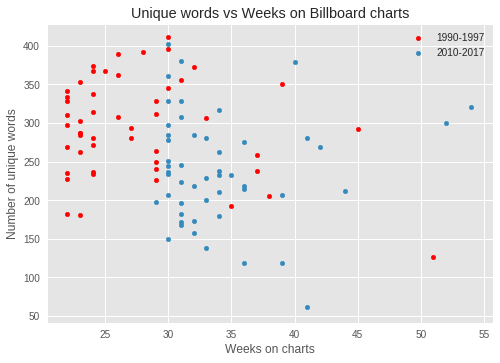

In [52]:
def num_unique_words(lyrics):
    ''' Split lyrics by spaces and count each word's number of occurrences '''
    words = re.split(r'\s+', lyrics)
    return len({ word for word in words })

def add_unique_words_col(df):
    ''' For each row, add a unique_words column with the number of unique words '''
    for i,row in df.iterrows():
        num_unique = num_unique_words(row['lyrics'])
        df.set_value(i, 'unique_words', num_unique)

add_unique_words_col(top_songs_90s)
add_unique_words_col(top_songs_10s)

ax = top_songs_90s.plot('weeks', 'unique_words', kind='scatter', c='r', label='1990-1997')
top_songs_10s.plot('weeks', 'unique_words', kind='scatter', ax=ax, label='2010-2017')

plt.title('Unique words vs Weeks on Billboard charts')
plt.xlabel('Weeks on charts')
plt.ylabel('Number of unique words')
plt.show()

When looking at our chart, the first thing to point out is that there does seem to be a bit of clustering going on for each time period. The '90s data points seem to be higher up on the y-axis, on average, than those from the 2010s. 

However, another important aspect of the plot is that it seems songs from the 2010s stayed on the Billboard charts longer than those from the 1990s. The majority of data points from the 2010s are further along the x-axis than those from the '90s. To see if this is true, let's chart the mean number of weeks for each dataset.

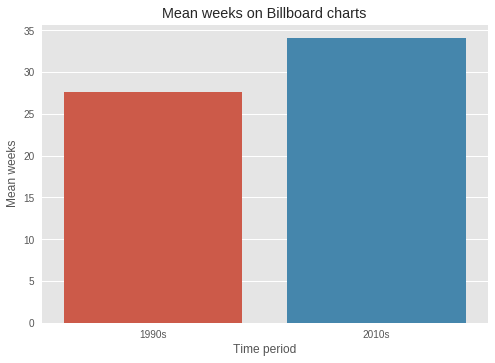

In [41]:
mean_90s = top_songs_90s['weeks'].mean()
mean_10s = top_songs_10s['weeks'].mean()

data = pd.DataFrame([{'time': '1990s', 'mean': mean_90s}, {'time': '2010s', 'mean': mean_10s}])
seaborn.barplot(x='time', y='mean', data=data)
plt.title('Mean weeks on Billboard charts')
plt.xlabel('Time period')
plt.ylabel('Mean weeks')
plt.show()

It's clear that though at first glance our 1990s songs have more unique words on average, our average number of weeks on the Billboard charts vary greatly. The reason for this likely has to do with the popularity of rap in the two time periods: nowadays, hip-hop music is everywhere. Many pop songs and songs from all types of genres are heavily rap- and trap-influenced, and even some of Taylor Swift's latest songs have a distinctive trap influence with the heavy use of hi-hat rolls and punching kicks. 

In order to account for the varying popularity of rap music across the two time periods, we'll plot the standardized weeks on the charts instead of the number of weeks themselves.

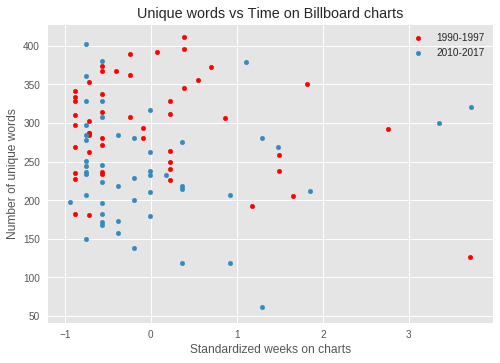

In [54]:
def standardize_weeks(df):
    mean = df['weeks'].mean()
    std = df['weeks'].std()
    df['weeks_std'] = (df['weeks'] - mean) / std
    
standardize_weeks(top_songs_90s)
standardize_weeks(top_songs_10s)

ax = top_songs_90s.plot('weeks_std', 'unique_words', kind='scatter', c='r', label='1990-1997')
top_songs_10s.plot('weeks_std', 'unique_words', kind='scatter', ax=ax, label='2010-2017')

plt.title('Unique words vs Time on Billboard charts')
plt.xlabel('Standardized weeks on charts')
plt.ylabel('Number of unique words')
plt.show()

With standardized weeks on the x-axis instead of the raw week number, we have a clearer picture of the distribution of unique words vs time spent on the charts. The distribution of the number of words for each time period tends to be generally a bit higher for the 1990s than for the 2010s, but let's use a violin plot to better visualize the comparison and take time on the charts out of the equation. 

While removing time on the Billboard charts takes away a visualization of a song's popularity compared to its unique words, we have already selected a sample of songs from the time period that represent the general public's opinion on rap fairly, as these are not 50 random songs from the population but rather the 50 most popular songs. With this in mind, a violin plot can help us better visualize the distribution of unique words in our samples.

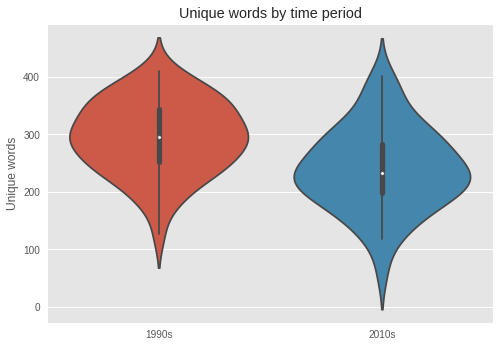

In [76]:
top_songs_both = []

for i,row in top_songs_90s.iterrows():
    top_songs_both.append({
        'time_period': 1990,
        'unique_words': row['unique_words']
    })
    
for i,row in top_songs_10s.iterrows():
    top_songs_both.append({
        'time_period': 2010,
        'unique_words': row['unique_words']
    })

top_songs_both = pd.DataFrame(top_songs_both)
seaborn.violinplot(x='time_period', y='unique_words', data=top_songs_both)
plt.title('Unique words by time period')
plt.xlabel('')
plt.xticks(range(2), ['1990s', '2010s'])
plt.ylabel('Unique words')
plt.show()

This gives us a much better visualization of the distribution of unique words for each time period, and it does in fact appear that the 50 most popular rap songs of the 1990s *did* have more unique words (in general) than those from the 2010s. For fun, let's see which song in the 2010s had the least number of unique words while still making a presence on the charts:

In [78]:
min_words = top_songs_10s['unique_words'].min()
top_songs_10s[top_songs_10s['unique_words'] == min_words]

,artist,song,weeks,lyrics,weeks_std,unique_words
5,Silento,Watch Me,41,You already know who it is Silentó Silentó Si...,1.295204,61.0


Though I knew Silento's "Watch Me" was a popular song in the last few years, admittedly I'm surprised at how long the song lasted on the charts with only an incredible *61 unique words*. If you're not familiar with the song, here's an excerpt from the lyrics:

> Now watch me whip, whip

> Watch me nae nae (Can you do it?)

> Now watch me, ooh watch me, watch me

> Ooh watch me, watch me

> Ooh watch me, watch me

> Ooh ooh ooh ooh

Despite being one of the most irritating songs to come out in the last decade, Silento's hit managed to stay on the charts for almost a full year before falling off. 

## Unique words vs. Compressibility

Throughout this analysis, we've used a track's number of unique words as a measure of its lyricism. Though imperfect, the idea is that unique words should give a decent estimate of how repetitive a song is. However, data scientist Colin Morris offers a rebuttal in his article [Are Pop Lyrics Getting More Repetitive?](https://pudding.cool/2017/05/song-repetition/) in which he points out that the following two verses have the same number of unique words, even though one is clearly more repetitive:

> baby I don't need dollar bills to have fun tonight

> I love cheap thrills

> baby I don't need dollar bills to have fun tonight

> I love cheap thrills

> I don't need no money

> as long as I can feel the beat

> I don't need no money

> as long as I keep dancing


(Sia, "Cheap Thrills")

> tonight I need dollar bills

> I don't keep fun

> cheap thrills long to feel money

> the bills don't need the dancing baby

> fun dollar dancing thrills the baby I need

> don't have fun

> no no don't have dancing fun tonight

> beat the can as I don't feel thrills

> love the dancing money

(Colin Morris, "Original composition")

As a solution, Morris uses the [Lempel-Ziv compression algorithm](https://en.wikipedia.org/wiki/LZ77_and_LZ78) to measure repetitiveness. LZ compression takes advantage of repeated sequences in order to reduce size. In the first verse, the LZ algorithm can eliminate entire lines ("baby I don't need dollar bills to have fun tonight") and word suffixes ("-ills") to reduce the size. 

To emulate this, we'll use python's `zlib` compression library which uses a variant of the LZ algorithm. We'll plot the reduction in size after compression instead of simply unique words:

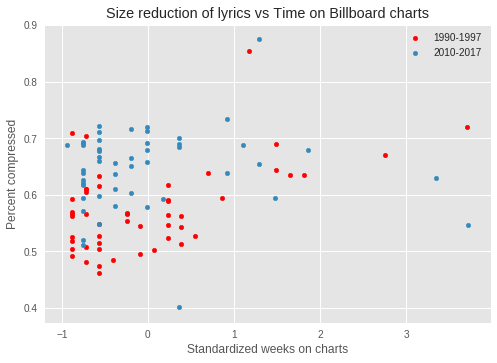

In [81]:
def compress_lyrics(df):
    for i, row in df.iterrows():
        orig_size = len(row['lyrics'])
        compressed = zlib.compress(bytes(row['lyrics'], 'utf-8'))
        compressed_size = len(compressed)
        percent_reduced = 1 - (compressed_size / orig_size)
        df.set_value(i, 'percent_reduced', percent_reduced)
        
compress_lyrics(top_songs_90s)
compress_lyrics(top_songs_10s)

ax = top_songs_90s.plot('weeks_std', 'percent_reduced', kind='scatter', c='r', label='1990-1997')
top_songs_10s.plot('weeks_std', 'percent_reduced', kind='scatter', ax=ax, label='2010-2017')

plt.title('Size reduction of lyrics vs Time on Billboard charts')
plt.xlabel('Standardized weeks on charts')
plt.ylabel('Percent compressed')
plt.show()

And the means of the reduction in size...

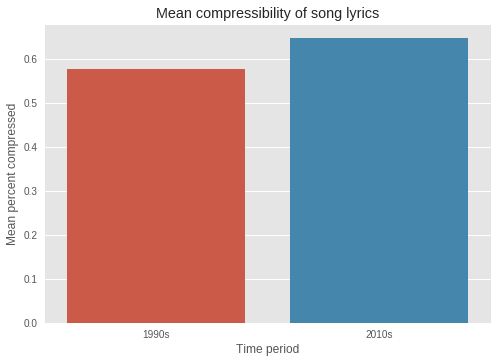

In [83]:
mean_90s = top_songs_90s['percent_reduced'].mean()
mean_10s = top_songs_10s['percent_reduced'].mean()

data = pd.DataFrame([{'time': '1990s', 'reduction': mean_90s}, {'time': '2010s', 'reduction': mean_10s}])
seaborn.barplot(x='time', y='reduction', data=data)
plt.title('Mean compressibility of song lyrics')
plt.xlabel('Time period')
plt.ylabel('Mean percent compressed')
plt.show()

It appears that this data lines up with our previous observation that popular songs in the 2010s are less lyrical and more repetitive than those in the 1990s. The mean percent compressibility of lyrics in the 2010s is around 65%, while those in the 1990s is closer to 58%. 

## Predicting unique words

Now that we've taken a look at unique words and lyric compressibility over time, let's employ a bit of [linear regression](https://en.wikipedia.org/wiki/Linear_regression) and see if we can find a predictive relationship between weeks on the Billboard charts and number of unique words for both time periods. 

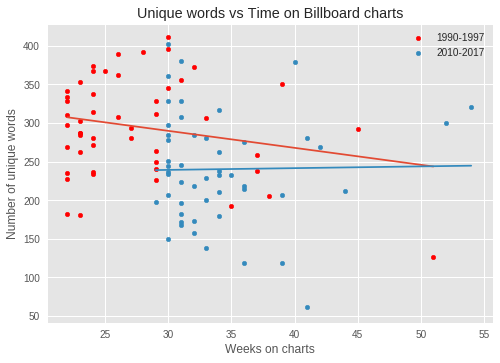

In [90]:
def get_linear_model(data, x, y):
    model = LinearRegression()
    X = [[x] for x in data[x].values]
    y = [[y] for y in data[y].values]
    model.fit(X, y)
    return model

model_90s = get_linear_model(top_songs_90s, 'weeks', 'unique_words')
model_10s = get_linear_model(top_songs_10s, 'weeks', 'unique_words')

unique_weeks_90s = [[x] for x in top_songs_90s['weeks'].unique()]
unique_weeks_10s = [[x] for x in top_songs_10s['weeks'].unique()]

ax = top_songs_90s.plot('weeks', 'unique_words', kind='scatter', c='r', label='1990-1997')
top_songs_10s.plot('weeks', 'unique_words', kind='scatter', ax=ax, label='2010-2017')
ax.plot(unique_weeks_90s, [y for [y] in model_90s.predict(unique_weeks_90s)])
ax.plot(unique_weeks_10s, [y for [y] in model_10s.predict(unique_weeks_10s)])

plt.title('Unique words vs Time on Billboard charts')
plt.xlabel('Weeks on charts')
plt.ylabel('Number of unique words')
plt.show()

It doesn't appear that the lines fit the data too well, but let's find the correlation coefficients to be sure.

In [98]:
result_90s = smf.ols(formula='unique_words ~ weeks', data=top_songs_90s).fit()
result_10s = smf.ols(formula='unique_words ~ weeks', data=top_songs_10s).fit()

print('1990s r_squared: {}'.format(result_90s.rsquared))
print('2010s r_squared: {}'.format(result_10s.rsquared))

1990s r_squared: 0.04804978848726338
2010s r_squared: 0.0002891657049349794


Unfortunately, it doesn't seem like there is much of a predictive relationship between weeks on the Billboard charts and unique words in a songs. Intuitively, this makes sense: a song's shorter-term (week-by-week) appeal has much more to do with other factors like lyrical content and production. By analyzing the top 50 songs of the time period, we have already chosen what the majority of listeners enjoyed the most at the time. The transient nature of the popularity of music makes it difficult to do any sort of fine-grain analysis on a week-by-week basis.

## Conclusion

After comparing the repetitiveness of the most popular rap songs from the 1990s and 2010s, it appears that the 1990s were in fact more lyrical -- at least in the "unique word choice" sense. 

It would be interesting to analyze some of the highly-regarded albums and songs of the time periods rather than the most popular, as the most popular songs may not be representative of the best songs of the time. As an example, Kendrick Lamar's *To Pimp a Butterfly*, which came out in 2015, had a few songs which entered the Billboard Hot 100, but none made it into our top 50. This album, however, is regarded as one of the best and most influential rap albums of all time. However, for the purposes of this analysis, I felt it would be better to go with the population's consensus rather than cherry-picking albums which I personally feel are representative of the time.

The musical preferences of society over a certain time period can speak volumes about the culture of the decade. Analyzing popular songs over various time periods can help answer questions about what listeners of the time might value, for what reasons they might listen to music, or maybe just what record companies are trying to push out. Lyricism, rhyme schemes, and wordplay are difficult to quantify, but I felt unique words and compressibility gave a decent estimate of a song's lyrical content. Although 90s rap was statistically more lyrical, to dub the decade the one true Golden Age of Rap based on repetitiveness alone would be neglecting many other important factors such as song content, wordplay, production, and the overall landscape of the genre's place in music at the time (which could be an entirely different analysis on its own).